## Instalação das bibliotecas

In [1]:
!pip install --upgrade langchain-text-splitters langchain-community langgraph

  Obtaining dependency information for langchain-text-splitters from https://files.pythonhosted.org/packages/a2/37/b2c971dfea62675f640e0dd5a078ca502885059276d21b7143cf1fe13e82/langchain_text_splitters-0.3.4-py3-none-any.whl.metadata
  Obtaining dependency information for langchain-community from https://files.pythonhosted.org/packages/45/a7/b9f3cd12510fe9a5fe2dcd7f12d095b0d5bd95fb2cd9c5362de45ebc18f9/langchain_community-0.3.13-py3-none-any.whl.metadata
  Obtaining dependency information for langgraph from https://files.pythonhosted.org/packages/93/ce/150789d181ea0570112c6fae330f477aa5f68fa425098c25c2c9b1556676/langgraph-0.2.60-py3-none-any.whl.metadata
  Obtaining dependency information for langchain-core<0.4.0,>=0.3.26 from https://files.pythonhosted.org/packages/9a/bf/07e63d4b4c41aa49daf4a4499e8010928ce8545469f0265544f925c95fff/langchain_core-0.3.28-py3-none-any.whl.metadata
  Obtaining dependency information for httpx-sse<0.5.0,>=0.4.0 from https://files.pythonhosted.org/packages/e1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
clarifai 9.8.1 requires tqdm==4.64.1, but you have tqdm 4.66.4 which is incompatible.
jupyter-server 1.13.5 requires pywinpty<2; os_name == "nt", but you have pywinpty 2.0.10 which is incompatible.


In [2]:
!pip install -U langchain-openai

  Obtaining dependency information for langchain-openai from https://files.pythonhosted.org/packages/ed/54/63c8264d7dbc3bf31ba61bf97740fdd76386b2d4f9a58f58afd3961ce7d7/langchain_openai-0.2.14-py3-none-any.whl.metadata
  Obtaining dependency information for openai<2.0.0,>=1.58.1 from https://files.pythonhosted.org/packages/8e/5a/d22cd07f1a99b9e8b3c92ee0c1959188db4318828a3d88c9daac120bdd69/openai-1.58.1-py3-none-any.whl.metadata
  Obtaining dependency information for jiter<1,>=0.4.0 from https://files.pythonhosted.org/packages/4e/1e/7f96b798f356e531ffc0f53dd2f37185fac60fae4d6c612bbbd4639b90aa/jiter-0.8.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/50.9 kB ? eta -:--:--
   ---------------------------------------- 50.9/50.9 kB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/454.3 kB ? eta -:--:--
   --------------------------------------- 454.3/454.3 kB 29.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/206.7 kB

Importando modelo

In [1]:
import os
from langchain_openai import ChatOpenAI

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = os.environ.get('OPEN_AI_KEY')

llm = ChatOpenAI(model="gpt-4o-mini")

Importando embeeding: O embeeding converte texto em vetor

In [2]:
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = os.environ.get('OPEN_AI_KEY')
    
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

Importa um Vector Store: Ele é que faz a busca no texto que você fez embeeding

In [3]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

Neste trecho vai carregar o site e dividir o conteúdo do texto do site que se fará RAG em chunks de tamanho 1000 

In [4]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Já faz o filtro do que realmente importa extrair do site.
bs4_strainer = bs4.SoupStrainer(class_=("biotop"))

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://www.statsf1.com/en/2024/abou-dhabi.aspx",),
    bs_kwargs={"parse_only": bs4_strainer},
)

docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 71 sub-documents.


Visualizando o arquivo

In [6]:
docs[0]

Document(metadata={'source': 'https://www.statsf1.com/en/2024/abou-dhabi.aspx'}, page_content="\n\nLe clash Russell vs. Verstappen\nLa guerre est déclarée entre George Russell et Max Verstappen. Huit jours plus tôt, au Qatar, le Néerlandais a été dépossédé de la pole position au profit du Britannique, sous prétexte qu'il aurait gêné celui-ci en roulant trop lentement à la fin des qualifications. Furieux, Verstappen a eu une vive altercation avec son adversaire à la sortie du collège des commissaires, puis a affirmé face caméra n'avoir «\xa0plus aucun respect\xa0» pour celui-ci. Là-bas, Russell a refusé de répondre, se contentant de mettre cette altercation au compte du caractère sanguin du pilote Red Bull. Mais à Abou Dhabi, il lâche les chiens. Dévoilant sa propre version des faits, il accuse Verstappen de l'avoir menacé verbalement. «\xa0Avant même que je dise un mot aux commissaires, il jurait contre ceux-ci, narre-t-il. Il était en colère avant même que je ne parle, mais au final, 

In [7]:
print(docs[0].page_content[:1000])



Le clash Russell vs. Verstappen
La guerre est déclarée entre George Russell et Max Verstappen. Huit jours plus tôt, au Qatar, le Néerlandais a été dépossédé de la pole position au profit du Britannique, sous prétexte qu'il aurait gêné celui-ci en roulant trop lentement à la fin des qualifications. Furieux, Verstappen a eu une vive altercation avec son adversaire à la sortie du collège des commissaires, puis a affirmé face caméra n'avoir « plus aucun respect » pour celui-ci. Là-bas, Russell a refusé de répondre, se contentant de mettre cette altercation au compte du caractère sanguin du pilote Red Bull. Mais à Abou Dhabi, il lâche les chiens. Dévoilant sa propre version des faits, il accuse Verstappen de l'avoir menacé verbalement. « Avant même que je dise un mot aux commissaires, il jurait contre ceux-ci, narre-t-il. Il était en colère avant même que je ne parle, mais au final, les faits sont les faits. Il allait trop lentement. Puis, quand je suis sorti du bureau des commissaires, i

Armazenando os documentos numa vector store

In [8]:
# Index chunks
document_ids = vector_store.add_documents(documents=all_splits)

In [9]:
document_ids[:10]

['d4052e82-d8ac-4a17-9206-b8bd5c44d84f',
 'fba685ff-abd4-4e62-a1a9-e9bdddb7714e',
 '4f6ec951-762e-4a5d-9bdc-caa63ec04380',
 '5d32b682-958b-4390-89cc-9e1bcc797cb8',
 '99bd0276-6509-4cc9-b448-2b67cba32443',
 '9ac22bd6-7774-4b31-a7ac-2eda19cda3ac',
 '2bc9a4fa-e06b-4576-b359-fd16de6ceba3',
 '1a3b61c0-6518-4d03-9f7d-25a9a2e511ed',
 '39cc0d42-22eb-4c37-bdee-6577b4b75c0a',
 '357f3204-c70d-4fc3-bac2-19a4179f1794']

Definir api key para o langchain pra rastreabilizar o chat abaixo

In [10]:
import os

print(os.environ.get("LANGCHAIN_TRACING_V2"))
print(os.environ.get("LANGCHAIN_API_KEY"))

True
123456


Criando o chat para a interação com o documento (RAG)

In [11]:
from langchain import hub


prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


Classe State controla o formato de entrada da mensagem para o chat

In [12]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


Essas duas funções fazem:  
    Retrieve - Recupera a vector store com o contexto da pergunta enviada  
    Generate - Faz a interação do chat

In [13]:
       
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Status de recuperação da mensagem numa RAG pela variável graph

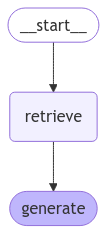

In [14]:
from langgraph.graph import START, StateGraph
from IPython.display import Image, display


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### Resposta utilizando Modelo GPT-4o-mini
Por conta da data de corte de treinamento do modelo, é esperado que ele não saiba quem venceu o GP de Abu Dhabi de 2024 que aconteceu em Dezembro de 2024

In [21]:
result = llm.invoke("Who won 2024 Abu Dhabi Grand Prix? Answer it in English")
print("Answer: ", result.content)

Answer:  I'm sorry, but I don't have information on events that occurred after October 2023, including the 2024 Abu Dhabi Grand Prix. You may want to check the latest sports news or official Formula 1 sources for the most up-to-date results.


### Resposta utilizando RAG

In [20]:
result = graph.invoke({"question": "Who won 2024 Abu Dhabi Grand Prix? Answer it in English"})

print(f'Context: {result["context"][0]}\n\n')
print(f'Answer: {result["answer"]}')

Context: page_content='Le Grand Prix
L'atmosphère est très douce (27°C) en ce début de soirée sur Yas Marina, mais la température de la piste est nettement plus basse que la veille (32°C au lieu de 42°C). Les pneumatiques devraient donc moins souffrir. Tous les pilotes partent en gommes médiums (C4), sauf Hamilton qui s'élance avec le composé dur (C3). Cette finale du championnat 2024 est un beau succès avec des tribunes remplies, notamment par les fans de Max Verstappen qui tiennent à fêter le quatrième sacre de leur idole.

Départ: Leclerc prend un bon envol tandis que Verstappen, très bien parti, double aussitôt Sainz, prend l'aspiration de Piastri, et se décale brusquement à l'intérieur au freinage pour surprendre ce dernier. Il est bien trop optimiste et touche la McLaren. Les deux bolides pirouettent, mais si Verstappen exécute un 360° et se relance au cœur du peloton, Piastri repart dernier après un tête-à-queue. Tsunoda peine à démarrer suite à un problème d'embrayage.' metadat